In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("patelris/crop-yield-prediction-dataset")

print("Path to dataset files:", path)

Path to dataset files: /home/eee/.cache/kagglehub/datasets/patelris/crop-yield-prediction-dataset/versions/1


In [2]:
!ls /home/eee/.cache/kagglehub/datasets/patelris/crop-yield-prediction-dataset/versions/1

pesticides.csv	rainfall.csv  temp.csv	yield.csv  yield_df.csv


In [3]:
yield_csv = "/home/eee/.cache/kagglehub/datasets/patelris/crop-yield-prediction-dataset/versions/1/yield_df.csv"

In [4]:
import pymc as pm
import pandas as pd
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
crop = pd.read_csv(yield_csv)
crop

,Unnamed: 0,Area,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
0,0,Albania,Maize,1990,36613,1485.0,121.00,16.37
1,1,Albania,Potatoes,1990,66667,1485.0,121.00,16.37
2,2,Albania,"Rice, paddy",1990,23333,1485.0,121.00,16.37
3,3,Albania,Sorghum,1990,12500,1485.0,121.00,16.37
4,4,Albania,Soybeans,1990,7000,1485.0,121.00,16.37
...,...,...,...,...,...,...,...,...
28237,28237,Zimbabwe,"Rice, paddy",2013,22581,657.0,2550.07,19.76
28238,28238,Zimbabwe,Sorghum,2013,3066,657.0,2550.07,19.76
28239,28239,Zimbabwe,Soybeans,2013,13142,657.0,2550.07,19.76
28240,28240,Zimbabwe,Sweet potatoes,2013,22222,657.0,2550.07,19.76


In [6]:
print("--- Dataframe Info ---")
crop.info()
print(crop.describe())


print("\n--- Valore únicos ---")
print("Num. países:", crop['Area'].nunique())
print("Num. tipos de crops:", crop['Item'].nunique())

--- Dataframe Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28242 entries, 0 to 28241
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     28242 non-null  int64  
 1   Area                           28242 non-null  object 
 2   Item                           28242 non-null  object 
 3   Year                           28242 non-null  int64  
 4   hg/ha_yield                    28242 non-null  int64  
 5   average_rain_fall_mm_per_year  28242 non-null  float64
 6   pesticides_tonnes              28242 non-null  float64
 7   avg_temp                       28242 non-null  float64
dtypes: float64(3), int64(3), object(2)
memory usage: 1.7+ MB
         Unnamed: 0          Year    hg/ha_yield  \
count  28242.000000  28242.000000   28242.000000   
mean   14120.500000   2001.544296   77053.332094   
std     8152.907488      7.051905   84956.612897   

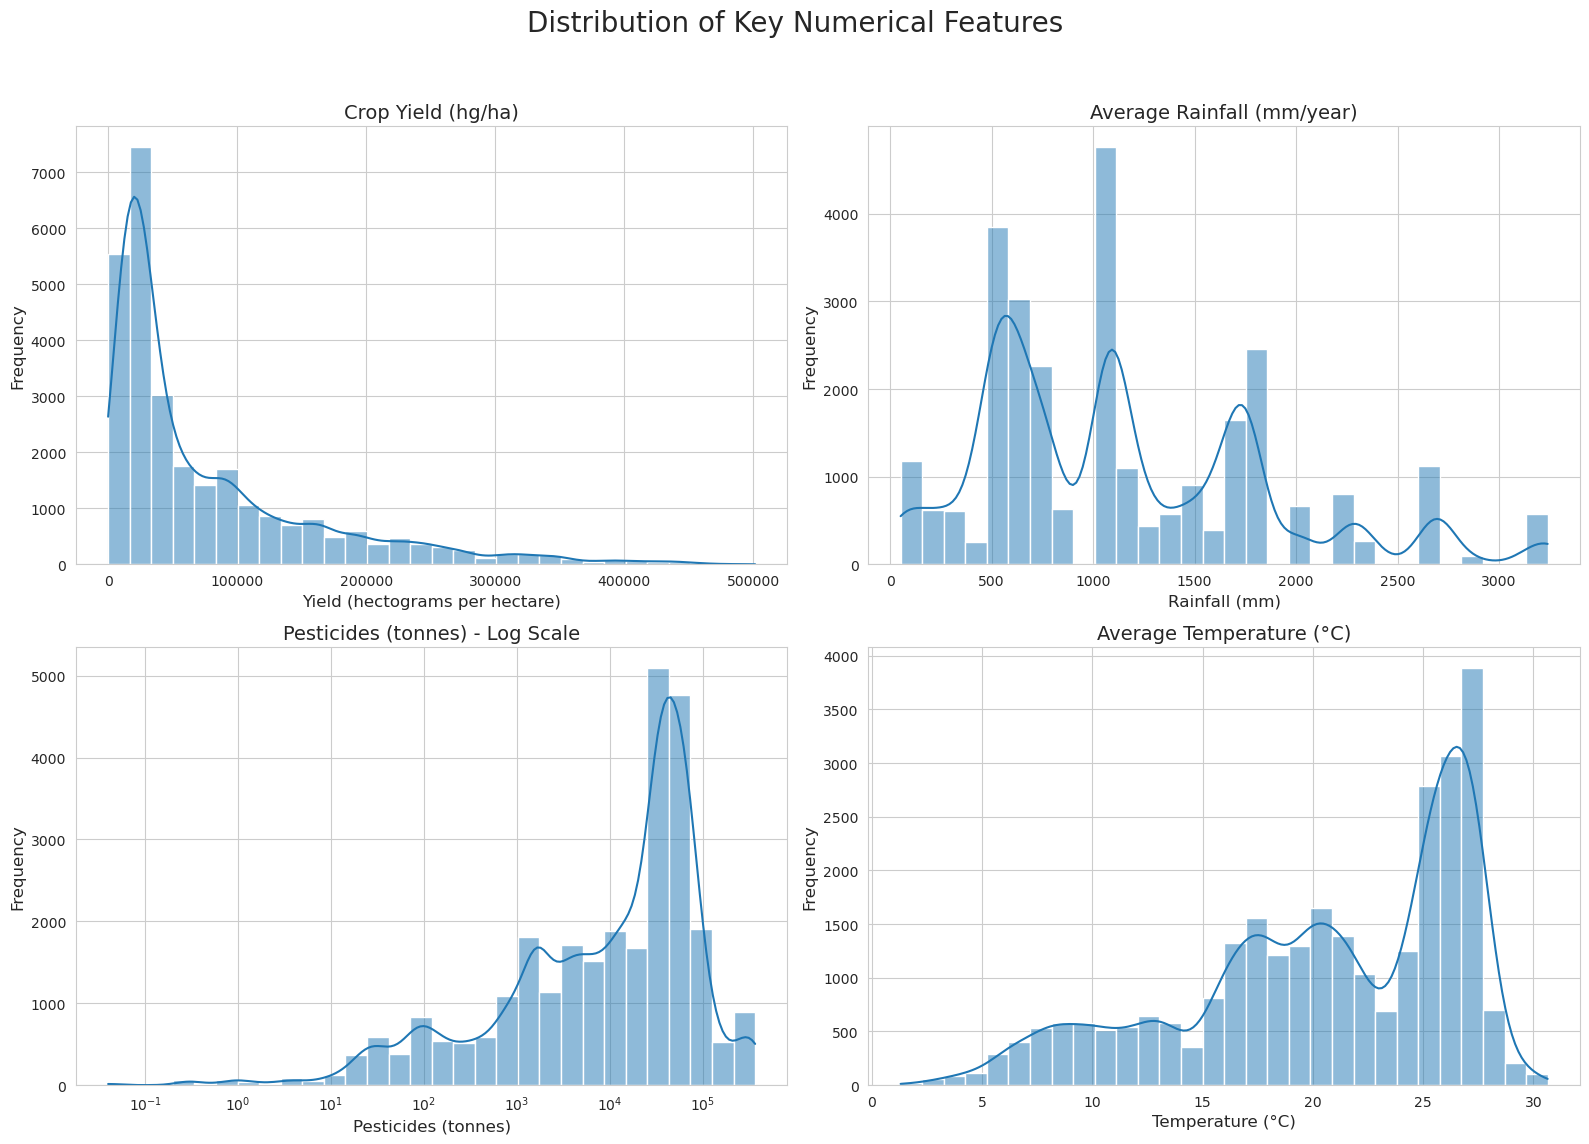

In [7]:
sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Distribution of Key Numerical Features', fontsize=20)

sns.histplot(crop['hg/ha_yield'], kde=True, ax=axes[0, 0], bins=30)
axes[0, 0].set_title('Crop Yield (hg/ha)', fontsize=14)
axes[0, 0].set_xlabel('Yield (hectograms per hectare)', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)

axes[0, 0].ticklabel_format(style='plain', axis='x')
sns.histplot(crop['average_rain_fall_mm_per_year'], kde=True, ax=axes[0, 1], bins=30)
axes[0, 1].set_title('Average Rainfall (mm/year)', fontsize=14)
axes[0, 1].set_xlabel('Rainfall (mm)', fontsize=12)
axes[0, 1].set_ylabel('Frequency', fontsize=12)

sns.histplot(crop['pesticides_tonnes'], kde=True, ax=axes[1, 0], bins=30, log_scale=True)
axes[1, 0].set_title('Pesticides (tonnes) - Log Scale', fontsize=14)
axes[1, 0].set_xlabel('Pesticides (tonnes)', fontsize=12)
axes[1, 0].set_ylabel('Frequency', fontsize=12)

sns.histplot(crop['avg_temp'], kde=True, ax=axes[1, 1], bins=30)
axes[1, 1].set_title('Average Temperature (°C)', fontsize=14)
axes[1, 1].set_xlabel('Temperature (°C)', fontsize=12)
axes[1, 1].set_ylabel('Frequency', fontsize=12)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


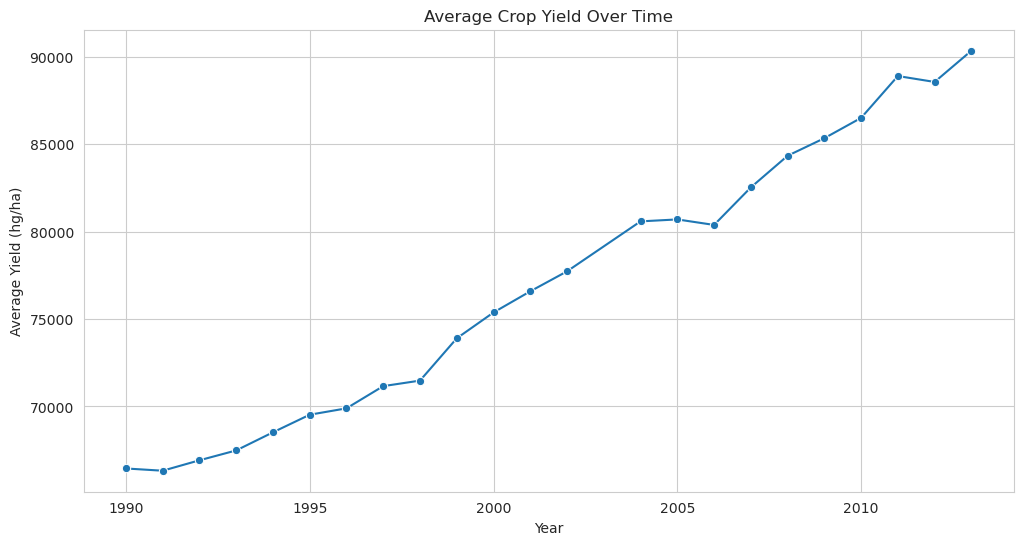

In [8]:

avg_yield_over_time = crop.groupby('Year')['hg/ha_yield'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x='Year', y='hg/ha_yield', data=avg_yield_over_time, marker='o')
plt.title('Average Crop Yield Over Time')
plt.xlabel('Year')
plt.ylabel('Average Yield (hg/ha)')
plt.grid(True)
plt.show()


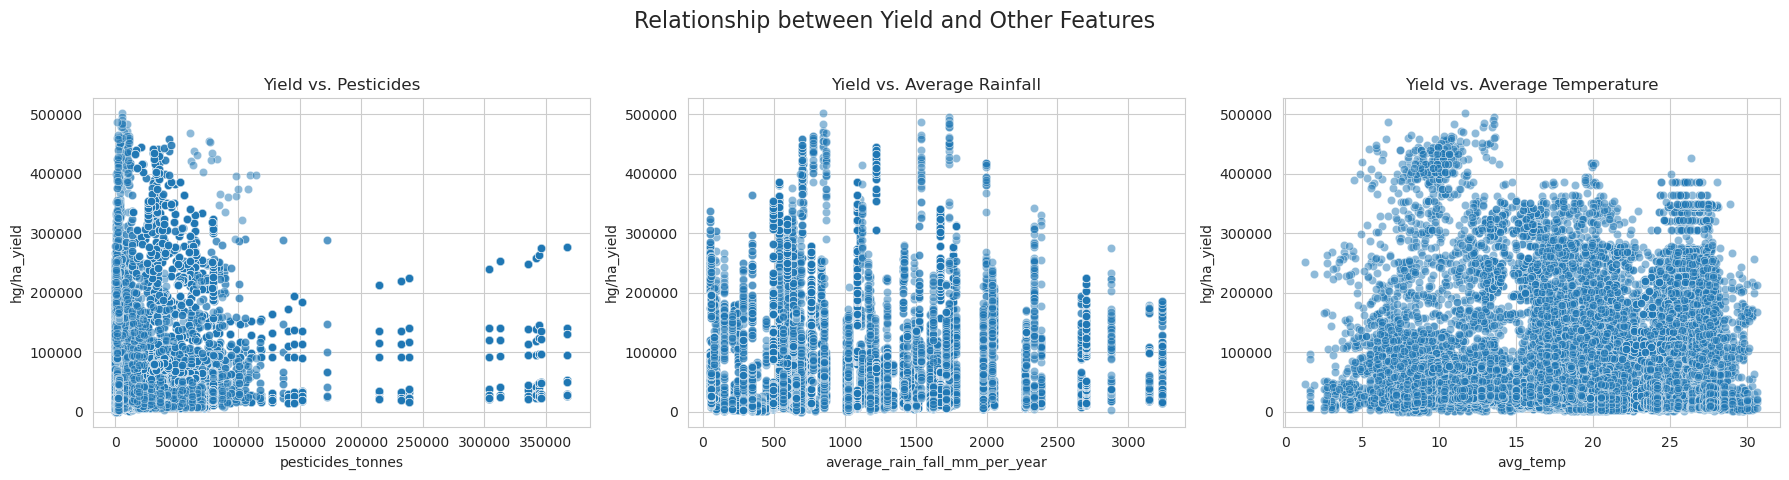

In [9]:

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Relationship between Yield and Other Features', fontsize=16)

sns.scatterplot(x='pesticides_tonnes', y='hg/ha_yield', data=crop, ax=axes[0], alpha=0.5)
axes[0].set_title('Yield vs. Pesticides')

sns.scatterplot(x='average_rain_fall_mm_per_year', y='hg/ha_yield', data=crop, ax=axes[1], alpha=0.5)
axes[1].set_title('Yield vs. Average Rainfall')

sns.scatterplot(x='avg_temp', y='hg/ha_yield', data=crop, ax=axes[2], alpha=0.5)
axes[2].set_title('Yield vs. Average Temperature')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


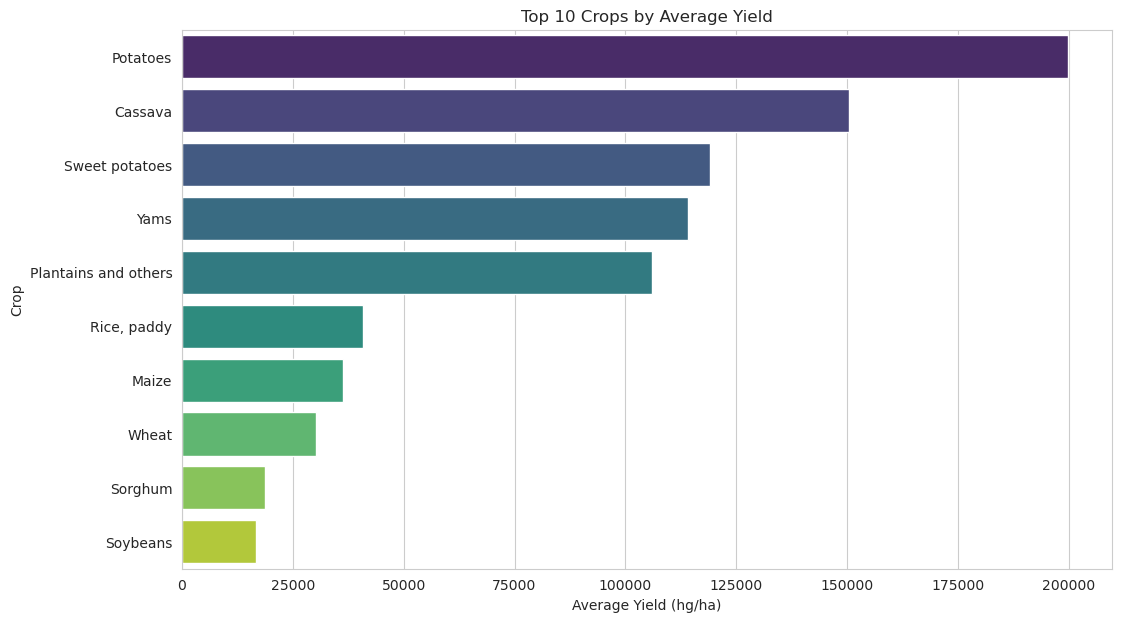

In [10]:

avg_yield_by_crop = crop.groupby('Item')['hg/ha_yield'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 7))
sns.barplot(x=avg_yield_by_crop.values, y=avg_yield_by_crop.index, palette='viridis', legend=False, hue=avg_yield_by_crop.index)
plt.title('Top 10 Crops by Average Yield')
plt.xlabel('Average Yield (hg/ha)')
plt.ylabel('Crop')
plt.show()



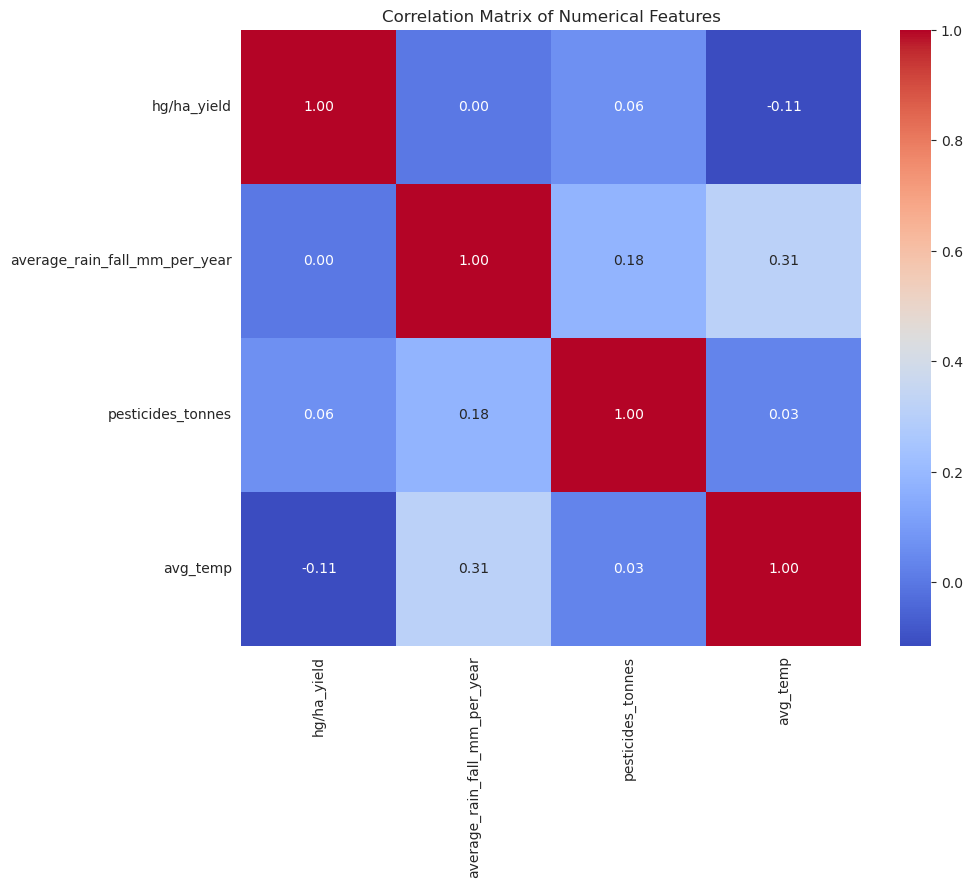

In [11]:
numerical_crop = crop[['hg/ha_yield', 'average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp']]

correlation_matrix = numerical_crop.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [12]:
crop["Item"].unique()

array(['Maize', 'Potatoes', 'Rice, paddy', 'Sorghum', 'Soybeans', 'Wheat',
       'Cassava', 'Sweet potatoes', 'Plantains and others', 'Yams'],
      dtype=object)

--- Starting EDA for: Potatoes ---

Descriptive Statistics:
         hg/ha_yield  average_rain_fall_mm_per_year  pesticides_tonnes  \
count    4276.000000                    4276.000000        4276.000000   
mean   199801.549579                    1060.399205       32152.516104   
std     93382.176418                     691.026858       53222.971160   
min      8406.000000                      51.000000           0.040000   
25%    140233.250000                     537.000000        1597.000000   
50%    182271.000000                     867.000000       14485.330000   
75%    253729.000000                    1513.000000       42482.560000   
max    501412.000000                    3240.000000      367778.000000   

          avg_temp  
count  4276.000000  
mean     19.007725  
std       7.061182  
min       1.300000  
25%      13.100000  
50%      20.040000  
75%      25.630000  
max      30.650000  


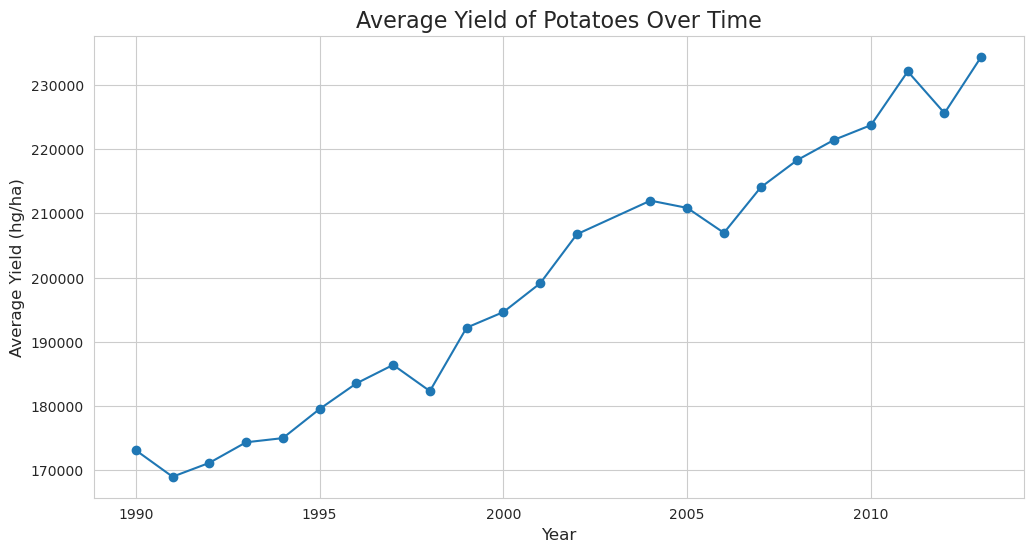

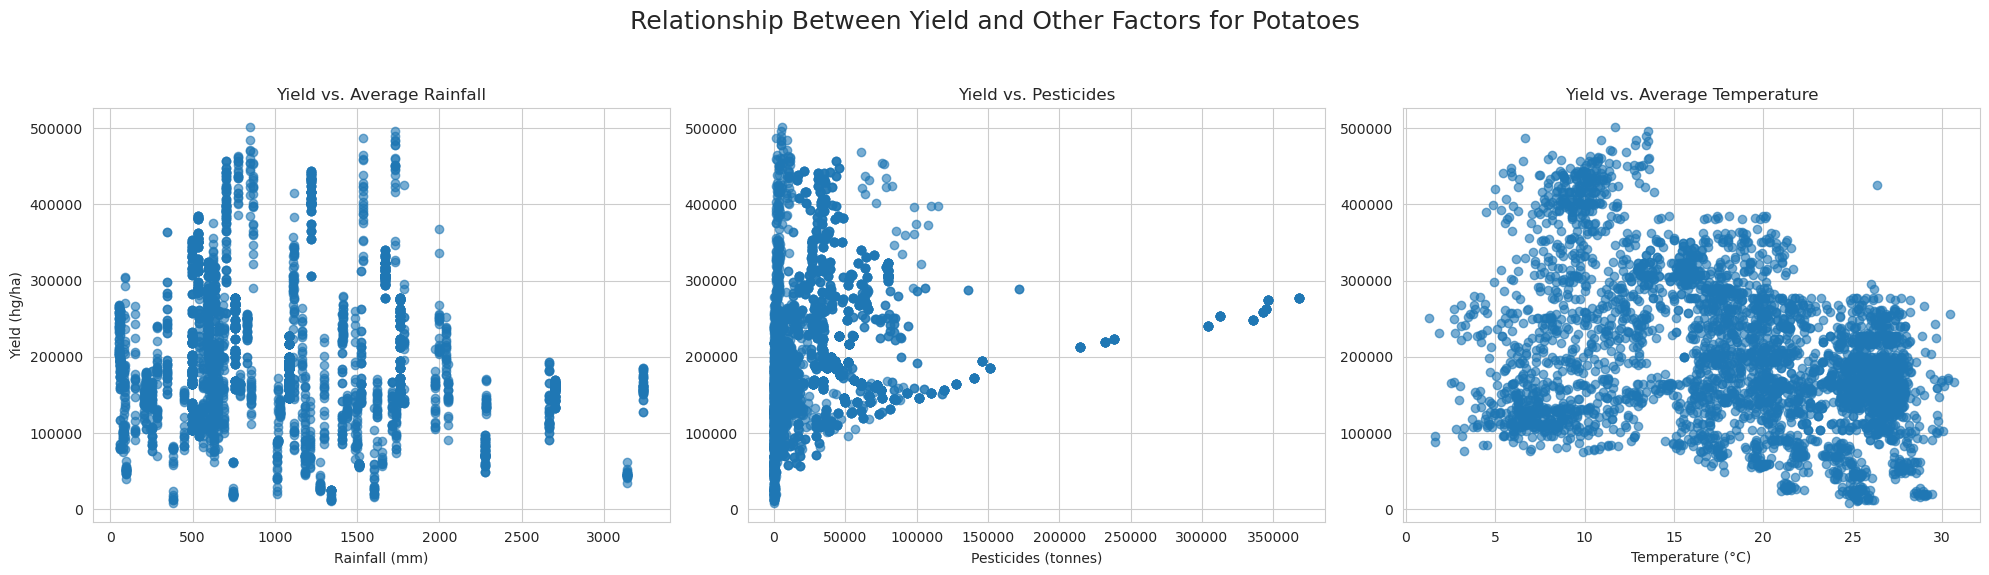

--- Finished EDA for: Potatoes ---


--- Starting EDA for: Cassava ---

Descriptive Statistics:
         hg/ha_yield  average_rain_fall_mm_per_year  pesticides_tonnes  \
count    2045.000000                    2045.000000        2045.000000   
mean   150479.466993                    1481.128606       44181.307457   
std     89738.515066                     689.934532       71198.065934   
min     11778.000000                     151.000000           0.040000   
25%     88492.000000                    1083.000000        1302.490000   
50%    128200.000000                    1212.000000       26156.000000   
75%    218232.000000                    1761.000000       55540.000000   
max    385818.000000                    3240.000000      367778.000000   

          avg_temp  
count  2045.000000  
mean     24.205756  
std       3.385827  
min      15.710000  
25%      21.500000  
50%      25.450000  
75%      26.930000  
max      30.420000  


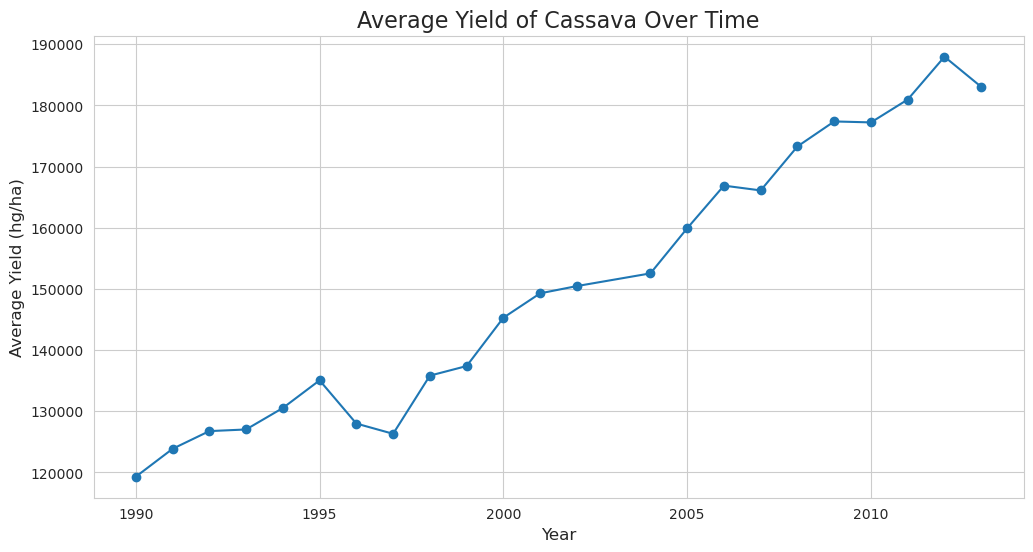

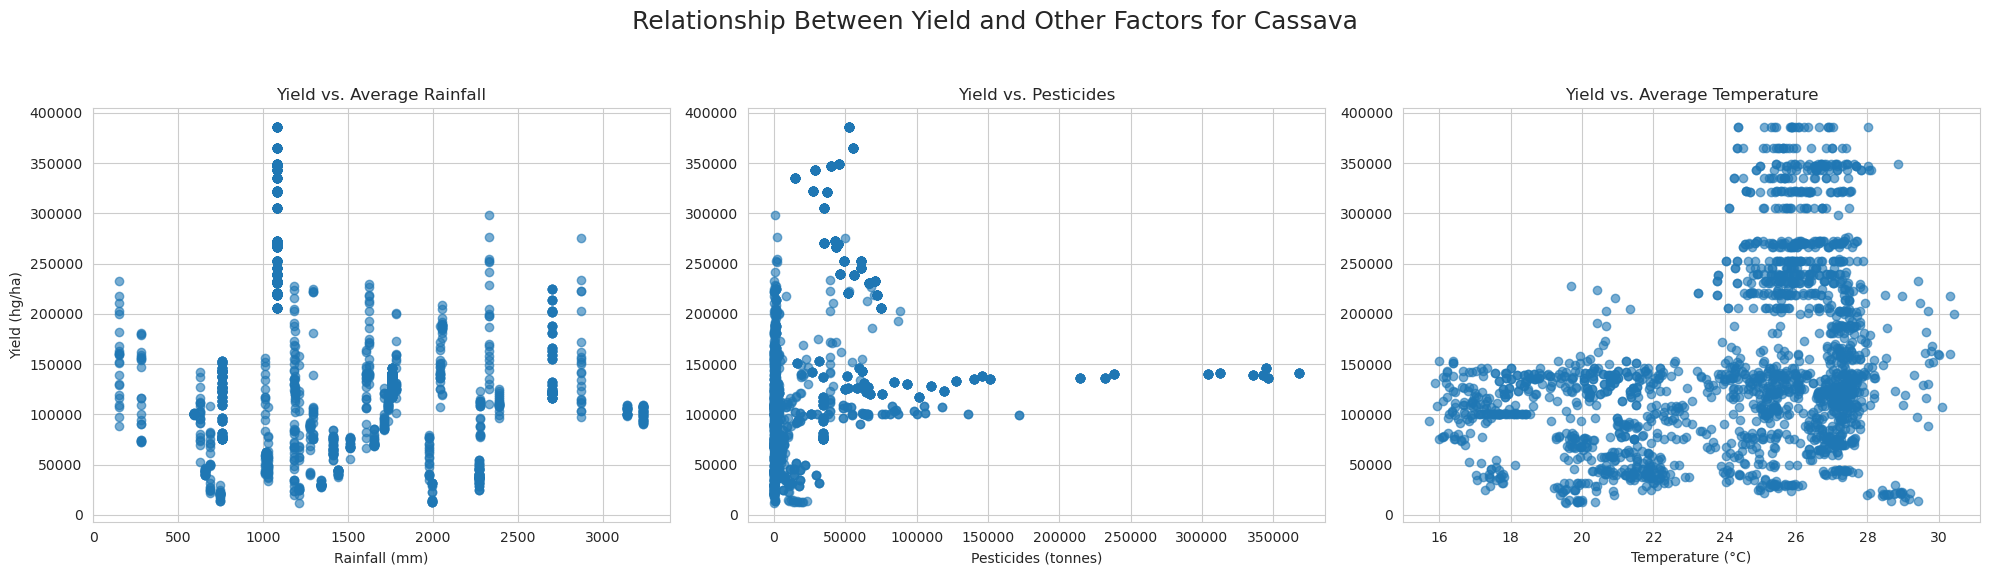

--- Finished EDA for: Cassava ---


--- Starting EDA for: Sweet potatoes ---

Descriptive Statistics:
         hg/ha_yield  average_rain_fall_mm_per_year  pesticides_tonnes  \
count    2890.000000                    2890.000000        2890.000000   
mean   119057.793772                    1232.128028       39448.289848   
std     69847.566716                     700.246315       61710.445366   
min      8799.000000                      51.000000           0.920000   
25%     80643.000000                     636.000000        2156.075000   
50%     99940.000000                    1083.000000       20773.200000   
75%    157526.500000                    1738.000000       52279.000000   
max    400000.000000                    3142.000000      367778.000000   

          avg_temp  
count  2890.000000  
mean     22.178668  
std       4.935659  
min       5.510000  
25%      18.200000  
50%      23.900000  
75%      26.360000  
max      30.650000  


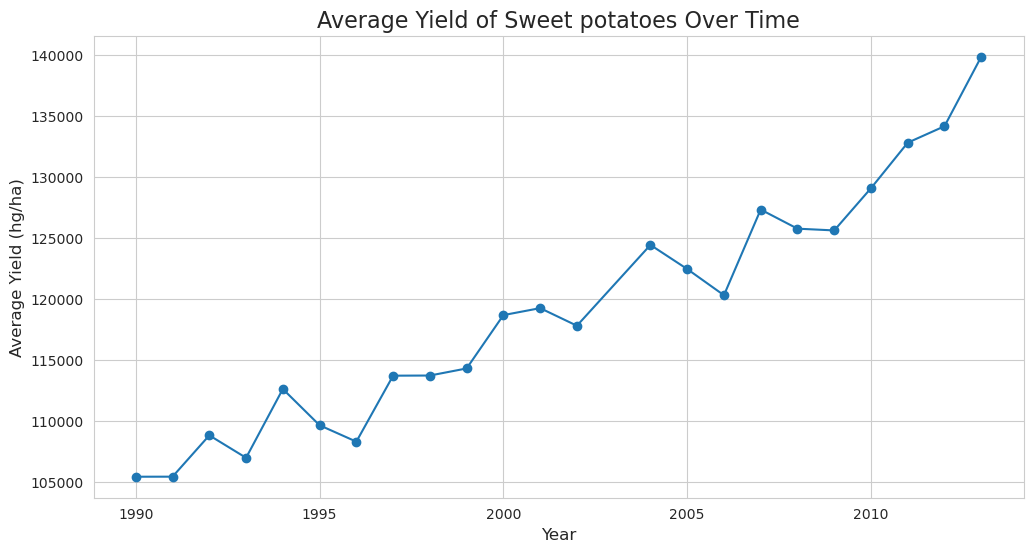

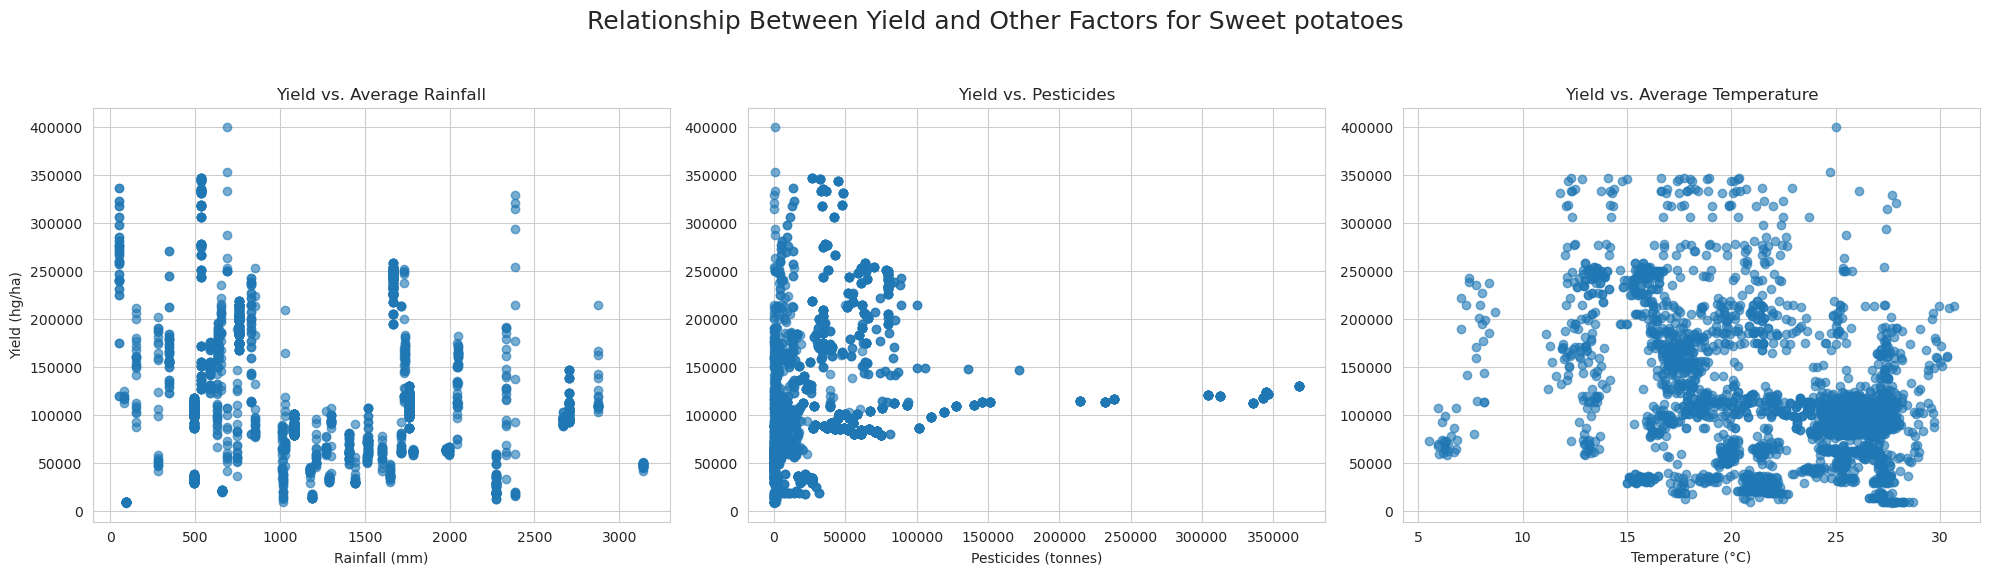

--- Finished EDA for: Sweet potatoes ---




In [13]:
to_explore = ["Potatoes", "Cassava", "Sweet potatoes"]

# Loop through each crop in the to_explore list
for item_name in to_explore:
    
    print(f"--- Starting EDA for: {item_name} ---")
    
    # 1. Filter the DataFrame for the current crop
    crop_specific = crop[crop['Item'] == item_name].copy()
    
    # 2. Display descriptive statistics for the specific crop
    print("\nDescriptive Statistics:")
    print(crop_specific[['hg/ha_yield', 'average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp']].describe())
    
    # --- Visualizations using Matplotlib ---
    
    # 3. Visualize Average Yield Over Time
    avg_yield_time = crop_specific.groupby('Year')['hg/ha_yield'].mean()
    
    plt.figure(figsize=(12, 6))
    plt.plot(avg_yield_time.index, avg_yield_time.values, marker='o', linestyle='-')
    plt.title(f'Average Yield of {item_name} Over Time', fontsize=16)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Average Yield (hg/ha)', fontsize=12)
    plt.grid(True)
    plt.show()
    
    # 4. Visualize relationships between yield and other features
    # Create a figure and a set of subplots.
    fig, axs = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle(f'Relationship Between Yield and Other Factors for {item_name}', fontsize=18)
    
    # Scatter plot for Yield vs. Rainfall
    axs[0].scatter(crop_specific['average_rain_fall_mm_per_year'], crop_specific['hg/ha_yield'], alpha=0.6)
    axs[0].set_title('Yield vs. Average Rainfall')
    axs[0].set_xlabel('Rainfall (mm)')
    axs[0].set_ylabel('Yield (hg/ha)')
    
    # Scatter plot for Yield vs. Pesticides
    axs[1].scatter(crop_specific['pesticides_tonnes'], crop_specific['hg/ha_yield'], alpha=0.6)
    axs[1].set_title('Yield vs. Pesticides')
    axs[1].set_xlabel('Pesticides (tonnes)')
    
    # Scatter plot for Yield vs. Temperature
    axs[2].scatter(crop_specific['avg_temp'], crop_specific['hg/ha_yield'], alpha=0.6)
    axs[2].set_title('Yield vs. Average Temperature')
    axs[2].set_xlabel('Temperature (°C)')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.94])
    plt.show()
    
    print(f"--- Finished EDA for: {item_name} ---\n\n")

## Relação entre rendimento e temperatura
modelo
$$y(t)=\alpha+\beta t+ \varepsilon$$
- $y(t)$ rendimento em relação à temperatura. 
- $\alpha$ intercepto do eixo y. Rendimento estimado para na ausência de variação de temperatura.
- $\beta$ coeficiente angular. taxa de variação do rendimento conforme temperatura.
- $\varepsilon$ erro do modelo.
- $t$ temperatura

In [14]:
item = "Potatoes"

product = crop[(crop["Item"] == item)]

product_crop = product[["avg_temp","hg/ha_yield"]]

t = product["avg_temp"]
obs = product["hg/ha_yield"]

with pm.Model() as model:
    a = pm.Normal("a", 190_000, 20_000)
    b = pm.Normal("b", -4000, 10_000)
    eps = pm.HalfNormal("eps", 10_000)

    likelihood = pm.Normal("y_obs",a+b*t,eps,observed=obs)

In [15]:
model

    a ~ Normal(1.9e+05, 2e+04)
    b ~ Normal(-4e+03, 1e+04)
  eps ~ HalfNormal(0, 1e+04)
y_obs ~ Normal(f(a, b), eps)

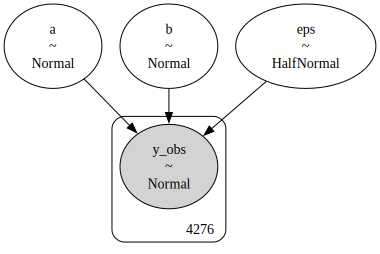

In [16]:
pm.model_to_graphviz(model)

In [17]:
with model:
  trace = pm.sample()

 Progress                    Draws   Divergences   Step size   Grad evals   Sampling Speed   Elapsed   Remaining  
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  ━━━━━━━━━━━━━━━━━━━━━━━━━   2000    0             0.35        11           256.21 draws/s   0:00:07   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━   2000    0             0.43        15           272.53 draws/s   0:00:07   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━   2000    0             0.29        7            253.68 draws/s   0:00:07   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━   2000    0             0.40        3            256.98 draws/s   0:00:07   0:00:00

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


In [18]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,289819.317,3762.953,282775.305,296830.720,110.064,79.882,1168.0,1609.0,1.0
b,-4758.978,186.468,-5117.566,-4419.776,5.627,4.011,1108.0,1250.0,1.0
eps,85929.658,914.455,84221.893,87613.657,19.810,15.387,2125.0,2010.0,1.0


array([<Axes: title={'center': 'a'}>, <Axes: title={'center': 'b'}>,
       <Axes: title={'center': 'eps'}>], dtype=object)

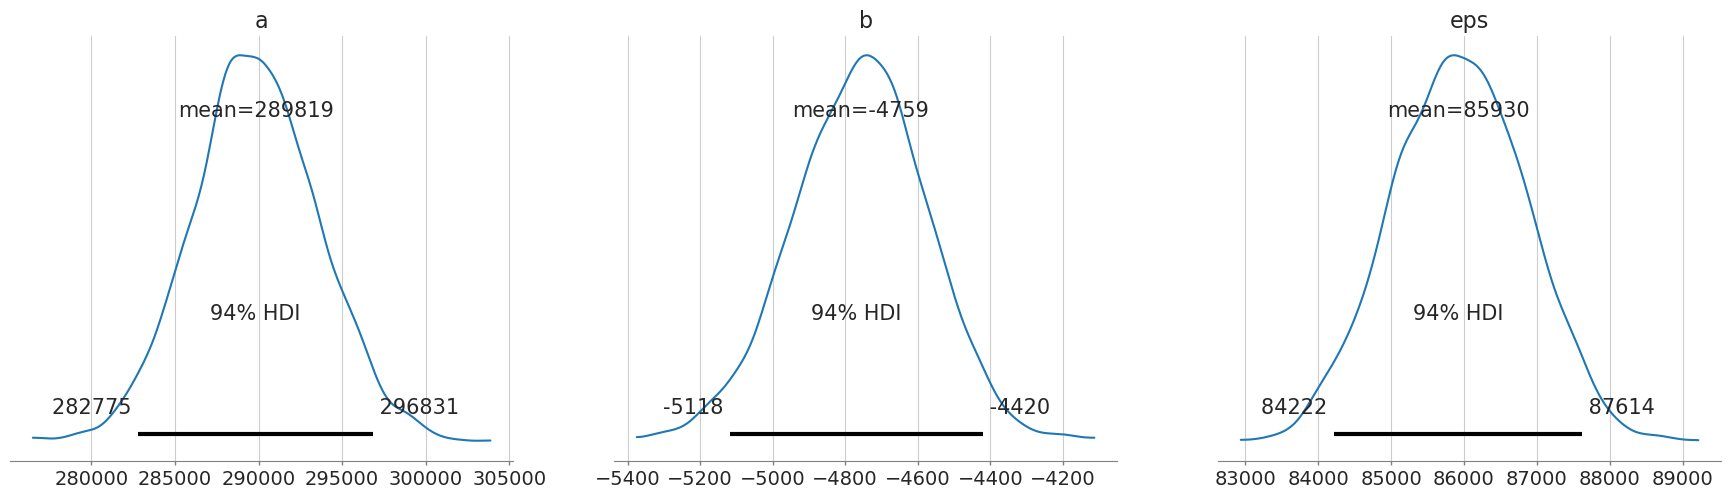

In [19]:
az.plot_posterior(trace)

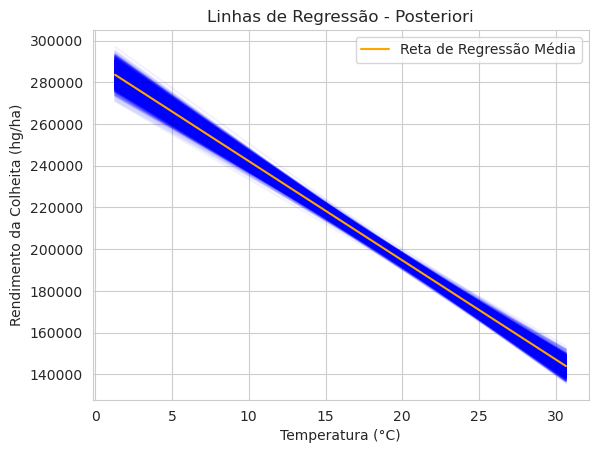

In [21]:
a_samples = trace.posterior["a"].values.flatten()
b_samples = trace.posterior["b"].values.flatten()
t_values = np.linspace(t.min(), t.max(), 100)

for a_sample, b_sample in zip(a_samples, b_samples):
    # x = t y = a+bt
    plt.plot(t_values, a_sample + b_sample * t_values, color="blue", alpha=0.05)

mean_a = a_samples.mean()
mean_b = b_samples.mean()
plt.plot(t_values, mean_a + mean_b * t_values, color="orange", label="Reta de Regressão Média")


plt.xlabel("Temperatura (°C)")
plt.ylabel("Rendimento da Colheita (hg/ha)")
plt.title("Linhas de Regressão - Posteriori")
plt.legend()
plt.show()

## Normalizado

In [26]:
obs = (obs - obs.mean())/obs.std()

with pm.Model() as model_norm:
  a = pm.Normal("a",0,1)
  b = pm.Normal("b",0,1)

  eps = pm.Normal("eps",0,1)

  likelihood = pm.Normal("y_obs",a+b*t,eps,observed=obs)

with model_norm:
  trace_norm = pm.sample()



 Progress                    Draws   Divergences   Step size   Grad evals   Sampling Speed   Elapsed   Remaining  
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  ━━━━━━━━━━━━━━━━━━━━━━━━━   2000    0             0.36        15           354.16 draws/s   0:00:05   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━   2000    0             0.40        11           348.86 draws/s   0:00:05   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━   2000    0             0.38        3            340.25 draws/s   0:00:05   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━   2000    0             0.23        7            353.14 draws/s   0:00:05   0:00:00

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


In [28]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,289819.317,3762.953,282775.305,296830.720,110.064,79.882,1168.0,1609.0,1.0
b,-4758.978,186.468,-5117.566,-4419.776,5.627,4.011,1108.0,1250.0,1.0
eps,85929.658,914.455,84221.893,87613.657,19.810,15.387,2125.0,2010.0,1.0


/tmp/nix-shell.4UH3QO/ipykernel_60365/101737814.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


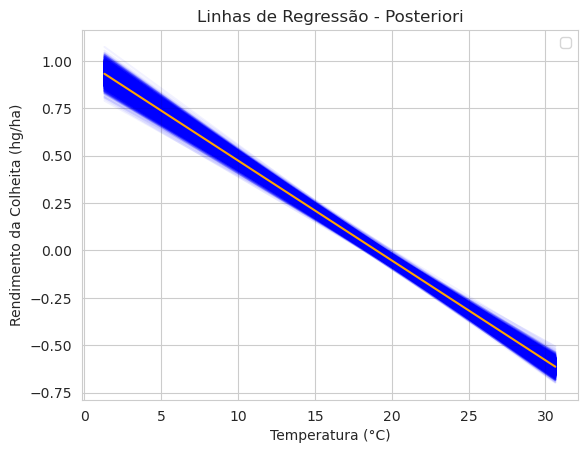

In [24]:
a_samples = trace_norm.posterior["a"].values.flatten()
b_samples = trace_norm.posterior["b"].values.flatten()
t_values = np.linspace(t.min(), t.max(), 100)

for a_sample, b_sample in zip(a_samples, b_samples):
    plt.plot(t_values, a_sample + b_sample * t_values, color="blue", alpha=0.05)

mean_a = a_samples.mean()
mean_b = b_samples.mean()
plt.plot(t_values, mean_a + mean_b * t_values, color="orange", )

#plt.scatter(t, obs_norm, color="red", alpha=0.5)

plt.xlabel("Temperatura (°C)")
plt.ylabel("Rendimento da Colheita (hg/ha)")
plt.title("Linhas de Regressão - Posteriori")
plt.legend()
plt.show()